In [1]:
from typing import Tuple

import numpy as np
import torch
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from torch import nn
from tqdm import trange
import seaborn as sns


In [2]:
X, y = make_moons(n_samples=1000)
X.shape

(1000, 2)

In [45]:
X

array([[ 0.24002093,  0.97076771],
       [ 0.33524768, -0.24706382],
       [ 1.39500896, -0.41867727],
       ...,
       [ 0.98953437,  0.14429736],
       [ 0.28956227, -0.20376007],
       [ 0.30662096,  0.9518317 ]])

In [3]:
import pickle

with open('data/paths.pkl', 'rb') as f:
    paths = pickle.load(f)
X = np.array(paths)  #[:, 0]
# x, y, theta1, theta2
X = X[:, :, [1, 3, 0, 2]]
print(X.shape)


(10000, 3001, 4)


In [4]:
X = torch.tensor(X, dtype=torch.float32)
L1, L2 = 1, 1
len_range = L1 + L2
ang_range = np.pi * 2
X[:, :, 0:2] /= len_range
X[:, :, 2:] /= ang_range
X

tensor([[[ 0.9012, -0.5628, -0.1439, -0.2373],
         [ 0.9202, -0.5202, -0.1410, -0.2390],
         [ 0.9386, -0.4758, -0.1380, -0.2406],
         ...,
         [-1.6671,  0.6742,  0.1430,  0.1446],
         [-1.7016,  0.6680,  0.1376,  0.1467],
         [-1.7304,  0.6525,  0.1321,  0.1488]],

        [[ 0.1325,  0.7296,  0.3401, -0.2458],
         [ 0.1047,  0.7545,  0.3405, -0.2434],
         [ 0.0771,  0.7795,  0.3408, -0.2410],
         ...,
         [-0.8318, -1.3840,  0.5829,  4.0991],
         [-0.8142, -1.3932,  0.5803,  4.0946],
         [-0.7966, -1.4015,  0.5777,  4.0902]],

        [[ 0.4561,  0.9554,  0.0141,  0.2495],
         [ 0.4625,  0.9016,  0.0155,  0.2524],
         [ 0.4672,  0.8479,  0.0170,  0.2552],
         ...,
         [ 0.6194,  0.8884, -0.0106,  0.2469],
         [ 0.6284,  0.8320, -0.0086,  0.2496],
         [ 0.6356,  0.7753, -0.0066,  0.2522]],

        ...,

        [[-0.0917,  0.1183,  0.3714,  0.0285],
         [-0.1364,  0.0852,  0.3710,  0.0288]

In [5]:
class ForwardProcess:
    def __init__(self, betas: torch.Tensor):
        self.beta = betas

        self.alphas = 1. - betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=-1)

    def get_x_t(self, x_0: torch.Tensor, t: torch.LongTensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward diffusion process given the unperturbed sample x_0.
        
        Args:
            x_0: Original, unperturbed samples.
            t: Target timestamp of the diffusion process of each sample.
        
        Returns:
            Noise added to original sample and perturbed sample.
        """
        eps_0 = torch.randn_like(x_0).to(x_0).to('cuda')
        alpha_bar = self.alpha_bar[t, None].unsqueeze(1).expand(-1, 3001, -1)
        mean = (alpha_bar ** 0.5) * x_0
        std = ((1. - alpha_bar) ** 0.5)

        return (eps_0, mean + std * eps_0)


In [6]:
T = 500  # Number of diffusion steps
betas = torch.linspace(0.0001, 0.02, T + 1, device='cuda') ** 4
fp = ForwardProcess(betas=betas)
x_t = X.clone().to('cuda')

In [7]:
fp.alphas.shape

torch.Size([501])

In [8]:
class NoisePredictor(nn.Module):

    def __init__(self, T):
        super().__init__()
        self.T = T
        self.t_encoder = nn.Linear(T, 1)

        self.model = nn.Sequential(
            nn.Linear(4 + 1, 100),  # Input: Noisy data x_t and t
            nn.LeakyReLU(inplace=True),
            # nn.Linear(100, 100),
            # nn.LeakyReLU(inplace=True),
            # nn.Linear(100, 100),
            # nn.LeakyReLU(inplace=True),
            nn.Linear(100, 20),
            nn.LeakyReLU(inplace=True),
            # Output: Predicted noise that was added to the original data point
            nn.Linear(20, 4),
        )

    def forward(self, x_t, t):
        # Encode the time index t as one-hot and then use one layer to encode
        # into a single value
        t_embedding = self.t_encoder(
            nn.functional.one_hot(t - 1, num_classes=self.T).to(torch.float)
        )
        t_embedding = t_embedding.unsqueeze(1).expand(-1, 3001, -1)
        inp = torch.cat([x_t, t_embedding], dim=-1)
        return self.model(inp)


In [9]:
model = NoisePredictor(T=T).to('cuda')
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-2, betas=(0.9, 0.999), weight_decay=1e-4)
loss_history = []
N = X.shape[0]
X = X.to('cuda')
for epoch in trange(1000):
    with torch.no_grad():
        # Sample random t's
        t = torch.randint(low=1, high=T + 1, size=(N,), device='cuda')

        # Get the noise added and the noisy version of the data using the forward
        # process given t
        eps_0, x_t = fp.get_x_t(X, t=t)
    eps_0 = eps_0.to('cuda')
    x_t = x_t.to('cuda')
    # Predict the noise added to x_0 from x_t
    pred_eps = model(x_t, t)

    # Simplified objective without weighting with alpha terms (Ho et al, 2020)
    loss = torch.nn.functional.mse_loss(pred_eps, eps_0)
    loss_history.append(float(loss))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
plt.plot(loss_history)

  0%|          | 0/1000 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.24 GiB. GPU 0 has a total capacity of 23.58 GiB of which 1.70 GiB is free. Including non-PyTorch memory, this process has 21.11 GiB memory in use. Of the allocated memory 20.72 GiB is allocated by PyTorch, and 84.18 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

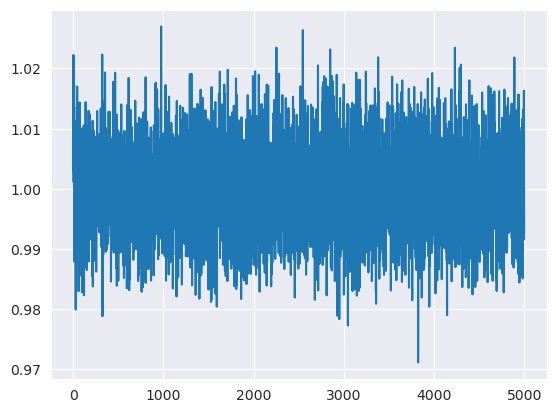

In [346]:
class ReverseProcess(ForwardProcess):
    def __init__(self, betas: torch.Tensor, model: nn.Module):
        super().__init__(betas)
        self.model = model.to('cuda')
        self.T = len(betas) - 1

        self.sigma = (
                             (1 - self.alphas)
                             * (1 - torch.roll(self.alpha_bar, 1)) / (1 - self.alpha_bar)
                     ) ** 0.5
        self.sigma[1] = 0.

    def get_x_t_minus_one(self, x_t: torch.Tensor, t: int) -> torch.Tensor:
        with torch.no_grad():
            t_vector = torch.full(size=(len(x_t),), fill_value=t, dtype=torch.long, device='cuda')
            eps = self.model(x_t, t=t_vector)
        print(eps)
        eps *= (1 - self.alphas[t]) / ((1 - self.alpha_bar[t]) ** 0.5)
        mean = 1 / (self.alphas[t] ** 0.5) * (x_t - eps)
        return mean + self.sigma[t] * torch.randn_like(x_t)

    def sample(self, n_samples=1, full_trajectory=False):
        # Initialize with X_T ~ N(0, I)
        x_t = torch.randn(n_samples, 4)
        trajectory = [x_t.clone()]

        for t in range(self.T, 0, -1):
            x_t = self.get_x_t_minus_one(x_t, t=t)

            if full_trajectory:
                trajectory.append(x_t.clone())
        return torch.stack(trajectory, dim=0) if full_trajectory else x_t


In [350]:
t = 4
n_samples = 1_000
x_t = torch.randn(n_samples, 4, device='cuda')
rp = ReverseProcess(betas=betas, model=model)
rp.get_x_t_minus_one(x_t, t=t)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [347]:

samples = rp.sample(n_samples=1_000).cpu().numpy()


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument tensors in method wrapper_CUDA_cat)

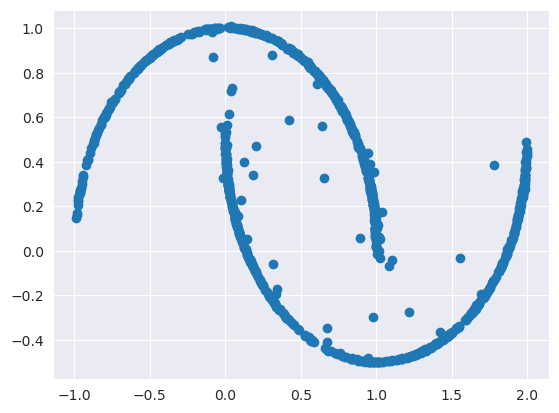

In [158]:
plt.scatter(samples[:, 0], samples[:, 1])